# Overview

Types of operations supported:

1. Insertion: For each insertion, we simply use k independent hash functions to generate k values, and set the corresponding slots on the boolean table to be True.
2. Look-up: We use the same set of hash functions to generate corresponding values, then see if all the slots are True. If so, we say the key exists (with small probability of false positive). If not, we say that the key certainly does not exist.
    
Types of operations not supported:

1. Object retrieval: Since the boolean table only store informaiton regarding whether a key exists, it does not provide a method for us to retrieve the object or a pointer to the object. 
2. Deletion: In the basic implementation of Bloom filters, it's not possible to delete a key. More advanced implementations such as counting filters allow deletion but with extra space requirement.
    
Applications:

1. Since comparing to a hash table, Bloom filters has better space efficiency but also introduces small false positive errors, they are good for large scale look-up tasks where false positive errors are not a big issue.
2. Many modern applications of Bloom filters are in dealing with network problems. Examples include:
    a. Cache filtering: Bloom filters can be used to determine which obects to store in web caches$^{[1]}$.
    b. Packet routing: Bloom filters can be used to speed up packet routing protocols$^{[2]}$.
    c. Resource routing: Bloom filters can used to improve efficiency in locating resources$^{[2]}$.
        
       
------------------------------------------
References

[1] Wikipedia. (n.d.) Bloom filter. Retrieved from
https://en.wikipedia.org/wiki/Bloom_filter#Cache_filtering

[2] Broder, A., & Mitzenmacher, M. (2004). Network applications of bloom filters: A survey. Internet mathematics, 1(4), 485-509.

# Implementation

In [140]:
from math import log
from operator import ior
from random import randint

def prime_larger_than(p):
    """A function that takes an integer and outputs the prime larger
    than the value (See References).
    
    """
    if p < 3: return 3
    if p % 2 == 0: p += 1
    while True:
        # Check if the number can be divided by any odd number between
        # 3 and sqrt(p)+1
        if all(p % n != 0 for n in xrange(3, int((p ** 0.5) + 1), 2)):
            return p
        # If not, try the next odd number
        p += 2

def get_uni_hash_func(table_size):
    """A function that randomly generates a universal integer hash
    function (See References).
    """
    prime = prime_larger_than(table_size)
    a = randint(1, prime-1)
    b = randint(0, prime-1)
    def hash_func(key):
        return (a*key+b) % prime % table_size
    return hash_func
    
class BloomFilter(object):
    """A Bloom filter data structure.
    
    
    Parameters
    ----------
    num_items : int
        The expected number of items to be stored. This value will
        be used to calculate optimal table parameters.
        
    false_pos : float
        The desired false positive probability (p) given the number
        of items (m) in a table of size (n). This is used to calc-
        ulate appropriate table size from n when not given, using
        the following equation (See References):
        
            (When the number of hash functions is chosen optimally)
            p ≈ 0.61^(n/m)
             
    table_size : float, default None
        Force table size to be the give value. When table_size is
        not given, it's calculated basing on fasle_pos and num_items.
    

    Attributes
    ----------
    num_hash : int
        The number of hash functions used. This is calculated optim-
        ally basing on the following equation (See References):
        
            k = log(2*n/m)
            
    table : int
        A binary vector that represents the table.
        
    hash_func : list of function pointers
        Stores `num_hash` number of independent universal hash functions.
    
    
    Methods
    -------
    add(key)
        Adding a key into the Bloom filter.
        
    __contains__(key)
        Checking whether a key exists in the Bloom filter.
    
    """
    def __init__(self, num_items=1000, false_pos=0.001, table_size=None):
        self.num_items = num_items
        if table_size is None:
            self.table_size = int(round(log(false_pos, 0.61)*num_items))
        else:
            self.table_size = table_size
        self.num_hash = max(1, int(round(log(2*log(false_pos, 0.6)))))
        self.table = 0
        self.hash_func = [get_uni_hash_func(self.table_size) 
                          for _ in xrange(self.num_hash)]
        
    def add(self, key):
        # Get hash values from hash functions
        hash_vals = [f(key) for f in self.hash_func]
        # Apply bitwise or operation on all slots associated with hash
        # values; add to the table
        self.table |= reduce(ior, [1 << x for x in hash_vals])
    
    def __contains__(self, key):
        # Get hash values from hash functions
        hash_vals = [f(key) for f in self.hash_func]
        # Checking whether all slots corresponding to hash values are
        # set to 1
        if all((self.table & (1 << x) != 0 for x in hash_vals)):
            return True
        return False

    def __repr__(self):
        return format(self.table, "b")[::-1]

    

-----------
References

Prime Number Generator: https://stackoverflow.com/questions/21043075/generating-large-prime-numbers-in-python

Universal Hashing Function: 
https://en.wikipedia.org/wiki/Universal_hashing#Hashing_integers

Bloom Filters:
https://www.youtube.com/watch?v=bEmBh1HtYrw


# Hash Functions

The hash functions this implementation uses are independent hash functions in a universal integer hash function family proposed by Carter and Wegman (1979). A function in that family is defined as:

$$ h_{a,b}(x) = ((ax + b)\mod p)\mod m$$

Where $m$ is the size of the universe, $p$ is a prime no less than $m$, and $a$ is a random integer in $[1, p-1]$ and $b$ is a random integer in $[0, p-1]$.

-------------
References

Carter, L., & Wegman, M. N. (1979). Universal Classes of Hash Functions. *Journal of Computer and System Sciences*. 18(2):143-154.


# Scaling Behavior

## Memory Size ~ False Positive Rate
In my implementation, table size $n$ is a function of false positive rate $p$ and number of items stored $m$, as following:

$$ n = m \cdot \log_{0.61}(p) = O(\lg(p)) $$

(given $m$ is constant)

Therefore, memory size (we mainly consider the table size, since it's the leading component) scales logarithmically with false positive rate.

## Memory Size ~ Number of Items Stored
From the equation above, we can also see that
$$n = m \cdot \log_{0.61}(p) = O(m)$$

(given $p$ is constant)

Therefore, memory size scales linearly with number of items stored.

## Access Time ~ Number of Items Stored
In my implementation, access time scales linearly with the number of hash functions because in each "\__contain\__" function call, values from each hash function are checked to see whether it exists in the table.

Number of hash functions $k$ in my implementation is set to be 
$$  k = \log(2\frac{n}{m}) = O(\lg(m))$$

(given $n$ is constant)

Therefore, access time scales logarithmically with number of items stored.


## Access Time ~ False Positive Rate
Combining $k = \log(2\frac{n}{m})$ and $p = 0.61^{\frac{n}{m}}$, we have
$$ k = \log(2\log_{0.61}(p)) = O(\lg(\lg p)) $$

Therefore, acess time scales double logarithmically with false positive rate.


# False Positive Rate Plot

In [141]:
INT_RANGE = 10000000
def add_integers(b, n):
    ints = []
    for i in xrange(n):
        ints.append(randint(0, INT_RANGE-1))
        b.add(ints[-1])
    return ints

N_TRIALS = 1000
def count_false_pos(b, real_vals):
    count = 0
    i = 0
    while i < N_TRIALS:
        val = randint(0, INT_RANGE-1)
        if val not in real_vals:
            if val in b:
                count += 1     
            i += 1
    return count      
            
N = 10000
N_DOTS = 100
num_items = 1000
fp_rate = []
theo_rate = []
for table_size in xrange(1, N+1):
    if table_size % (N/N_DOTS) == 0:
        b = BloomFilter(num_items=num_items, table_size=table_size)
        real_vals = add_integers(b, num_items)
        fp_rate.append(count_false_pos(b, real_vals)/float(N_TRIALS))
        theo_rate.append(0.61**(table_size/float(num_items)))

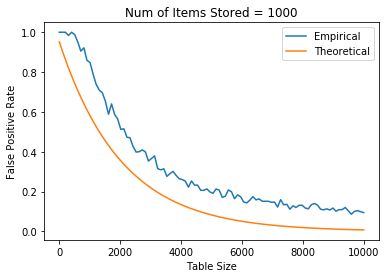

In [142]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x_vals = np.linspace(0, N, N_DOTS)
plt.plot(x_vals, fp_rate, label="Empirical")
plt.plot(x_vals, theo_rate, label= "Theoretical")
plt.xlabel("Table Size")
plt.ylabel("False Positive Rate")
plt.title("Num of Items Stored = {}".format(num_items))
plt.legend()